 La medicina es cara
==
<strong>El coste de los seguros médicos varía bastante según las circunstancias de cada persona, pero
a veces averiguar como se calcula realmente no es tan sencillo. El conjunto de datos Medical
Cost Personal Dataset2
tiene la descripción de las características de un grupo de personas
y los cargos de su seguro médico. Nos interesa predecir esta última variable (charges).
Trabajaremos con una versión de este conjunto que podéis obtener mediante la función
load_medical_cost de la librería apafib. Resuelve los siguientes apartados ilustrando los
resultados de la manera que te parezca más adecuada.</strong>

## <strong>a) Divide el conjunto de datos en entrenamiento y test (70 %/30 %). Haz una exploración mínima del conjunto de datos de entrenamiento observando las relaciones entre las variables, especialmente con la variable objetivo. Describe las cosas que hayas visto que te parezcan interesantes. Transforma las variables adecuadamente para poder ajustar un modelo de regresión tanto el conjunto de entrenamiento como el de test.</strong>

In [435]:
!pip install pandas --upgrade --user --quiet
!pip install numpy --upgrade --user --quiet
!pip install scipy --upgrade --user --quiet
!pip install statsmodels --upgrade --user --quiet
!pip install scikit-learn --upgrade --user --quiet
!pip install missingno --upgrade --user --quiet
!pip install apafib --upgrade --user --quiet
!pip install nbformat --upgrade --quiet --user
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [436]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import set_config

from yellowbrick.regressor import AlphaSelection

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')

sns.set()
pd.set_option('display.precision', 3)

In [437]:
try:
    from apafib import load_medical_costs
    medical = load_medical_costs()
except: 
    medical = pd.read_csv("./medical_costs.csv", header=0, delimiter=',')

medical.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.924
1,18,male,33.770,1,no,southeast,1725.552
2,28,male,33.000,3,no,southeast,4449.462
3,33,male,22.705,0,no,northwest,21984.471
4,32,male,28.880,0,no,northwest,3866.855


In [438]:
from sklearn.model_selection import train_test_split

In [439]:
medical.sex.unique()
medical.region.unique()
medical.smoker.unique()


array(['female', 'male'], dtype=object)

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

array(['yes', 'no'], dtype=object)

In [440]:
medical['sex'] = medical['sex'].astype('category')
medical['region'] = medical['region'].astype('category')
medical['smoker'] = medical['smoker'].astype('category')
medical.sex.unique()
medical.region.unique()
medical.smoker.unique()

['female', 'male']
Categories (2, object): ['female', 'male']

['southwest', 'southeast', 'northwest', 'northeast']
Categories (4, object): ['northeast', 'northwest', 'southeast', 'southwest']

['yes', 'no']
Categories (2, object): ['no', 'yes']

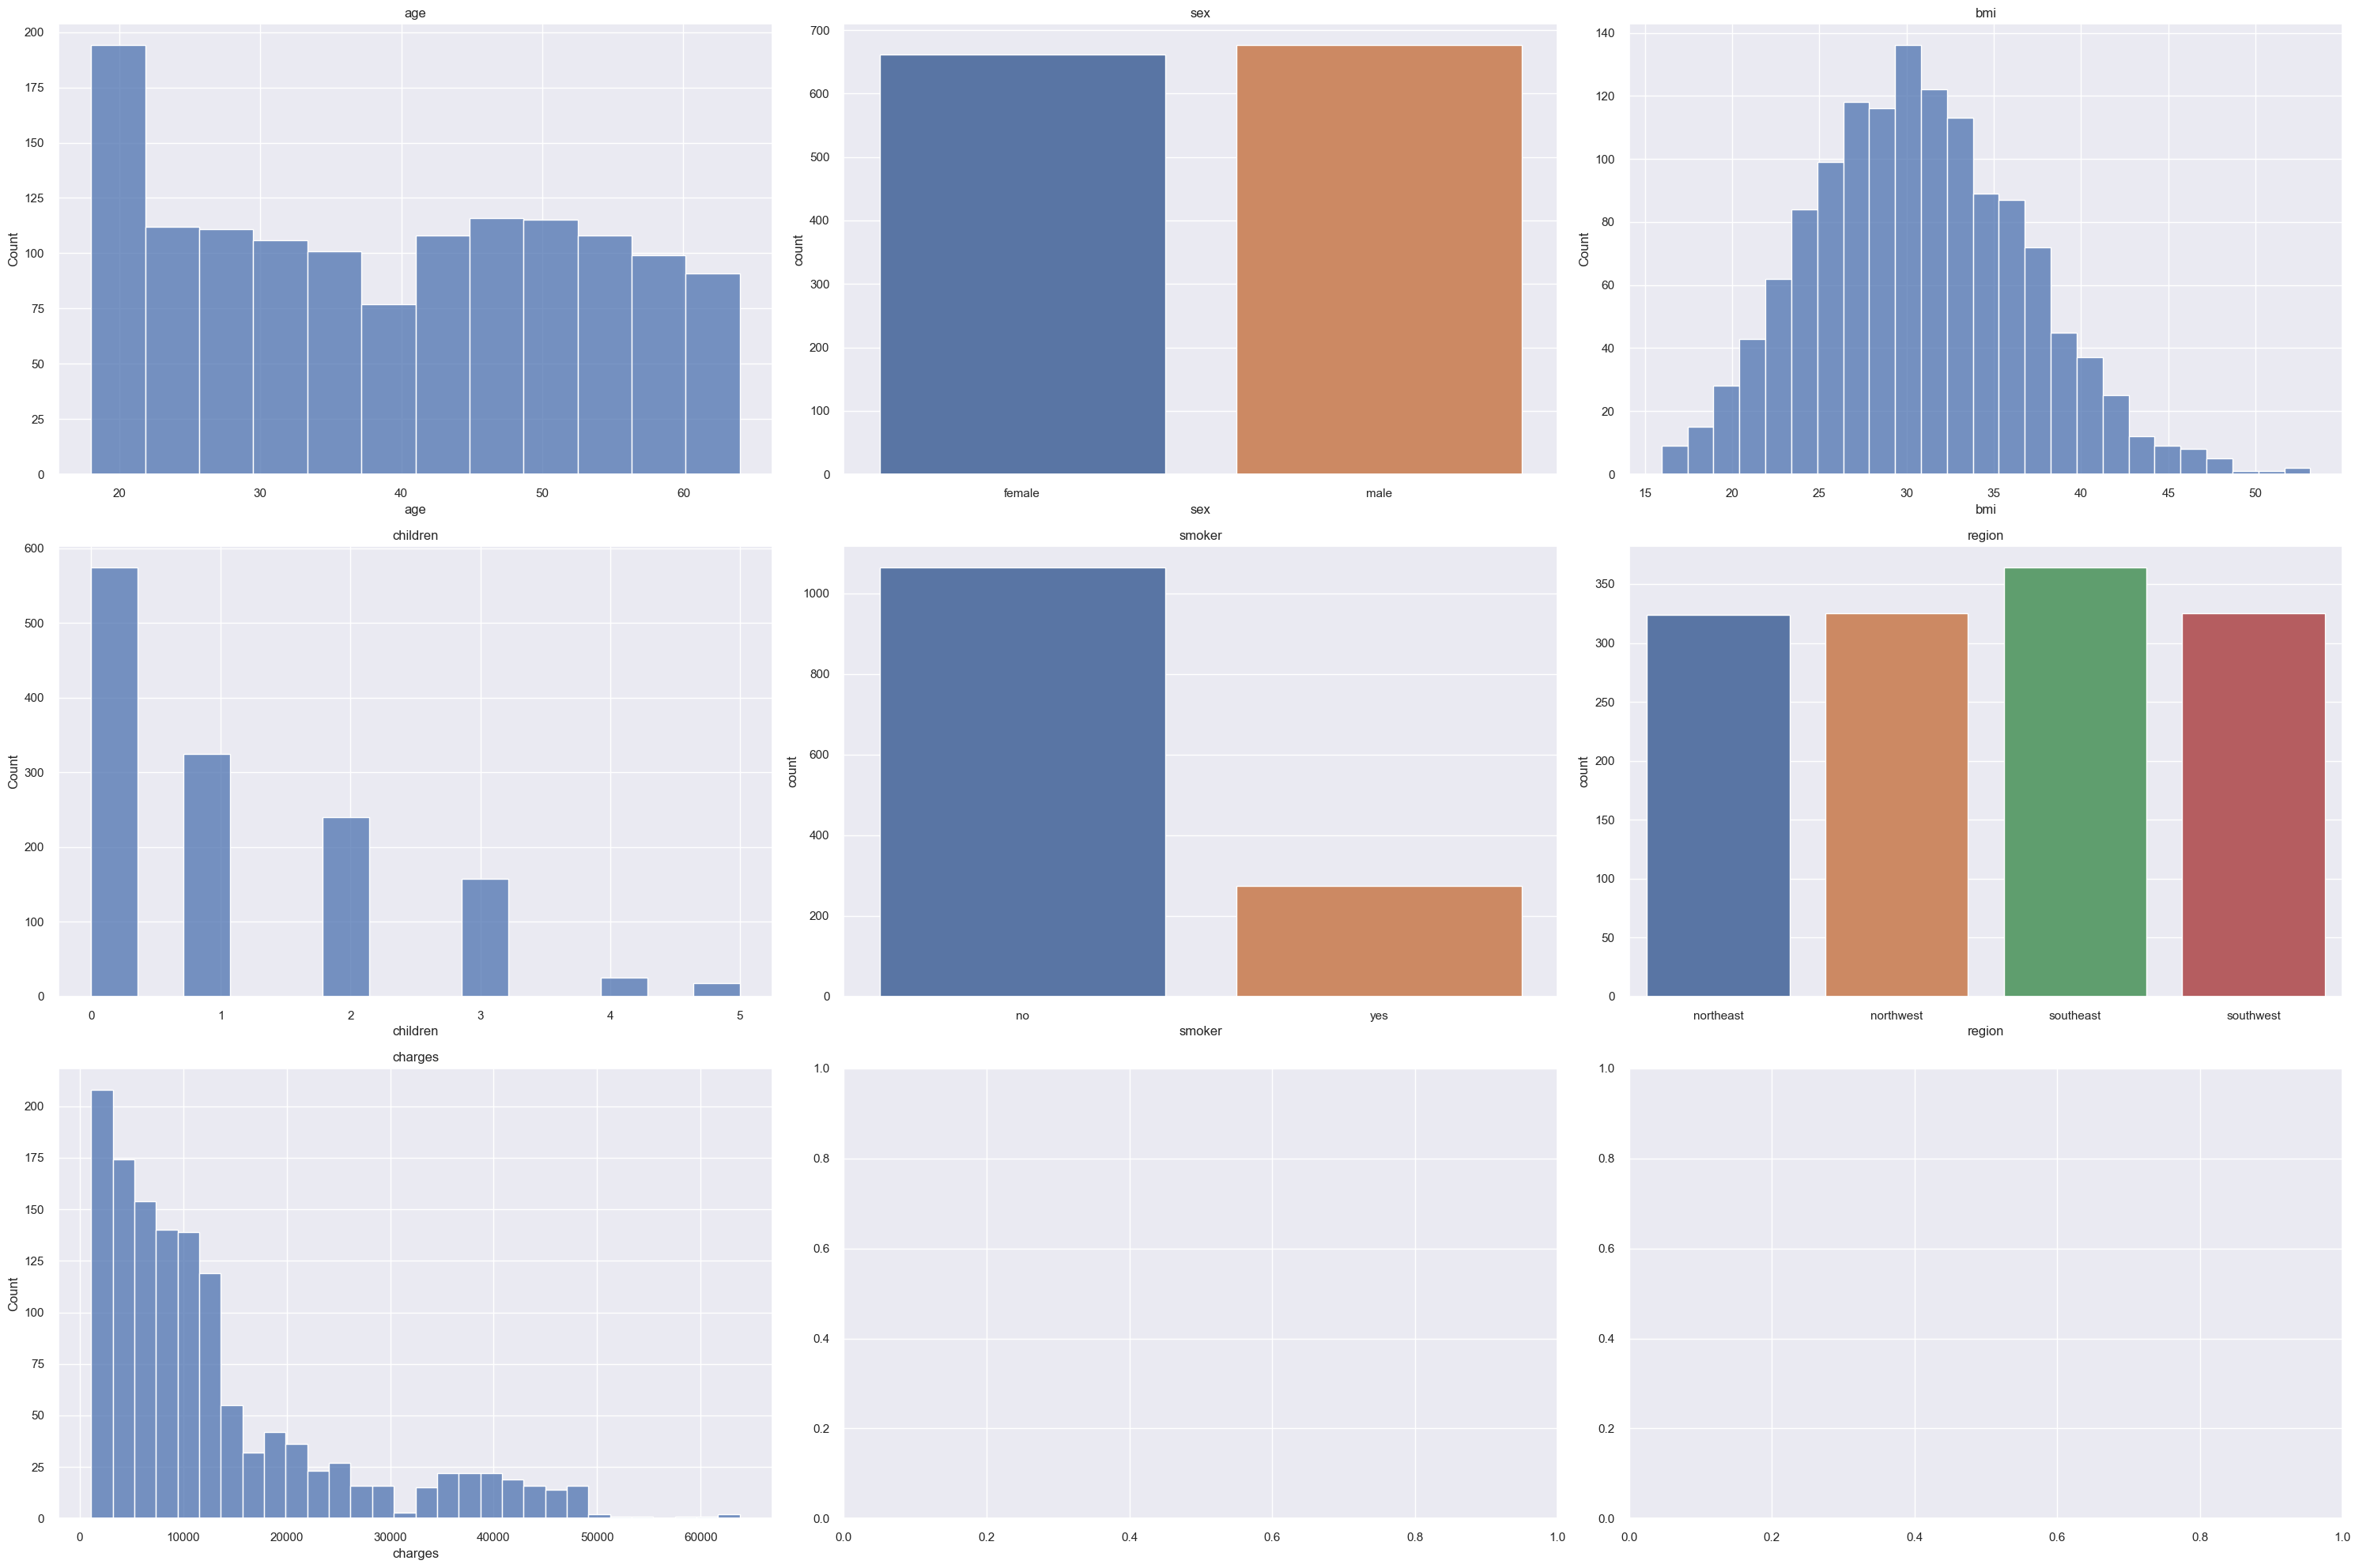

In [441]:
##miramos la distribución de las variables numéricas

fig, axes = plt.subplots(3,3,figsize=(30,20))


for i, c in enumerate(medical.columns[0:]):
    ax = axes.reshape(-1)[i]
    if medical[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=medical,ax=ax)
    else:
        b = sns.histplot(x=c,data=medical,ax=ax)
    t = ax.set_title(c)
plt.tight_layout()

podemos ver que los datos contienen una muestra representativa de la población en general, podemos ver que tanto el rango de dades como el bmi, la region i el sexo estan bien repartidos

#### Procedemos a mirar que variables categoricas estan relacionadas con los cargos y cuales no 

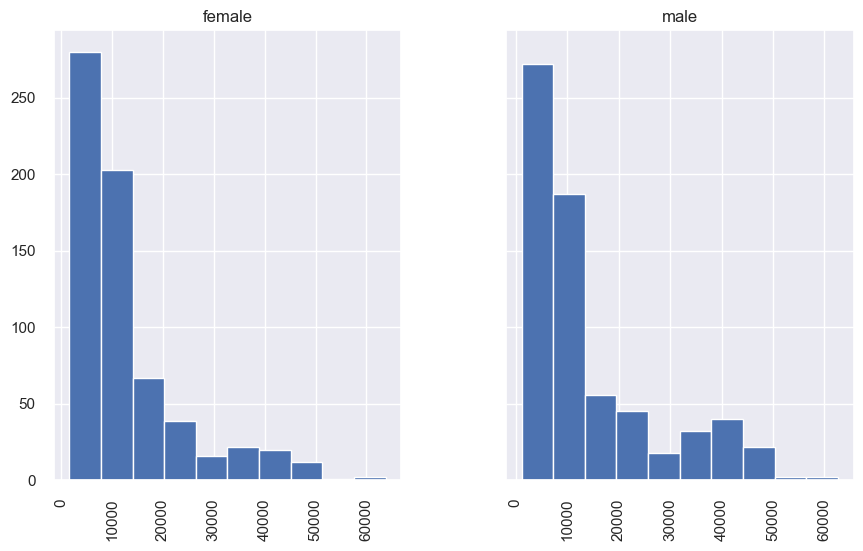

In [442]:
medical.hist(column='charges',by='sex',bins=10, sharey=True, figsize=(10,6), layout=(1,2));

podemos ver aqui que los costos parecen seguir la misma distribución independientemente del sexo


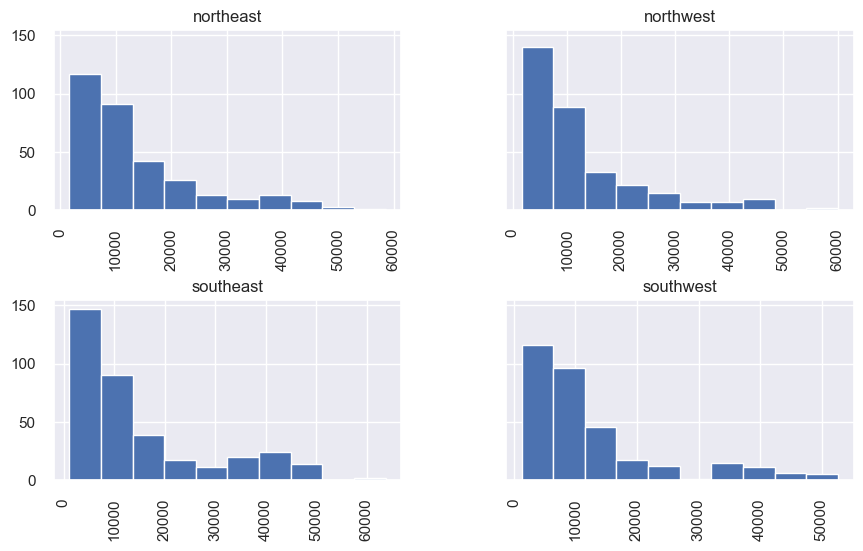

In [443]:
medical.hist(column='charges',by='region',bins=10, sharey=True, figsize=(10,6), layout=(2,2));


tambien podemos ver aqui que los costos parecen seguir la misma distribución independientemente de la región

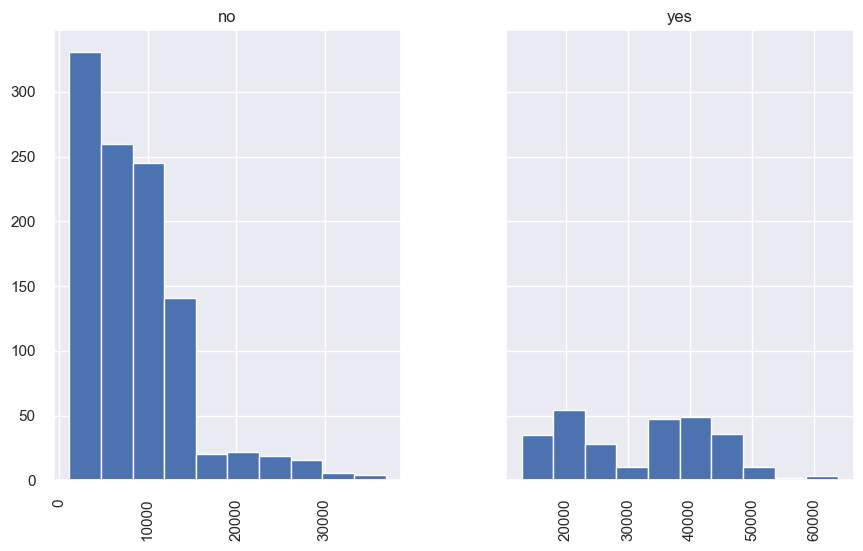

In [444]:
medical.hist(column='charges',by='smoker',bins=10, sharey=True, figsize=(10,6), layout=(1,2));

podemos ver que el ser o no fumador si que afecta bastante a la distribución del coste, siendo mas caros  para los fumadores

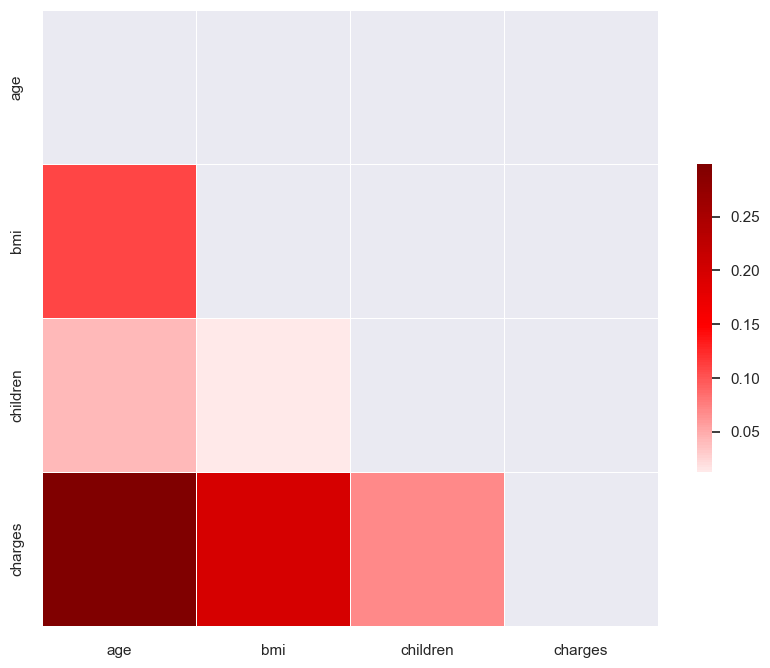

In [445]:
corr = medical.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

en la matriz de correlacion podemos ver que la edad es un factor muy decisivo para el coste, asi como el bmim aunque a menor escala

In [446]:
medical['sex'] = medical['sex'].astype('category')
medical['region'] = medical['region'].astype('category')
medical['smoker'] = medical['smoker'].astype('category')
X = medical.loc[:,medical.columns != 'charges']
y = medical['charges']

## X contiente todos los datos menos los cargos, mientras que t solo tiene los cargos (mismo indice)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.head()

,age,sex,bmi,children,smoker,region
332,61,female,31.160,0,no,northwest
355,46,male,27.600,0,no,southwest
138,54,female,31.900,3,no,southeast
381,55,male,30.685,0,yes,northeast
292,25,male,45.540,2,yes,southeast


In [447]:
##funcion para un preprocessado sencillo, simplemente borra las variables categoricas
def minimum_preprocessing(X, y):
    print('Tamaño original:{}'.format(X.shape))
    categorical_columns = X.dtypes[X.dtypes == 'category'].index.values
    # Eliminamos variables categoricas
    X=X.drop(columns=categorical_columns)
    print('Eliminadas: {}'.format(categorical_columns))
    # Eliminamos valores perdidos
    X=X.dropna()
    y=y[X.index]
    print('Nuevo tamaño:{}'.format(X.shape))
    return X, y

In [448]:
X_train, y_train = minimum_preprocessing(X_train,y_train)
X_test, y_test = minimum_preprocessing(X_test,y_test)
##quitamos las variables categoricas

Tamaño original:(936, 6)
Eliminadas: ['sex' 'smoker' 'region']
Nuevo tamaño:(936, 3)
Tamaño original:(402, 6)
Eliminadas: ['sex' 'smoker' 'region']
Nuevo tamaño:(402, 3)


## <strong>b) Ajusta un modelo de regresión lineal para predecir la variable objetivo y estima la calidad de la regresión. ¿Te parece suficientemente bueno el resultado? Representa los residuos y comenta que aparece.</strong>

### Regresion básica (eliminamos las variables categoricas)

Modelamos nuestra función de regresión como

 $y = f(x) + \epsilon = w^\top x + \epsilon$
 
 dónde:
 * $y$ es nuestro objetivo.
 * $w$ son los pesos que calcularemos.
 * $x$ son nuestras muestras.
 * $\epsilon$ es el ruido de las muestras.

 Si asumimos que el ruido es gaussiano, resolver este problema equivale a minimizar el error cuadrático medio de esta función.

$\min_w || y-Xw ||^2$

In [449]:
# Instanciamos el modelo LinearRegression 
lr = LinearRegression();

# Ajustamos con los datos de entrenamiento con el método fit
lr.fit(X_train,y_train);

# Predecimos con el método predict 
y_pred = lr.predict(X_train);
weights = lr.coef_
intercept = lr.intercept_
# Podemos acceder a información del modelo, como los pesos.
print('Coeficientes: \n', weights[:10])
print('Interceptor: \n', intercept)

LinearRegression()

Coeficientes: 
 [229.03485881 335.55393246 641.68292213]
Interceptor: 
 -6558.44454239259


In [450]:
from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
model = sm.OLS(y_train, sm.add_constant(X_train))
result = model.fit()
result.summary()
##podemos ver que el valor de p es 0 para la edad i el bmi, 
# las variables que habiamos visto que tenian mayor con el coste en la matriz de covarianza

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     40.20
Date:                Thu, 27 Oct 2022   Prob (F-statistic):           1.96e-24
Time:                        06:40:55   Log-Likelihood:                -10071.
No. Observations:                 936   AIC:                         2.015e+04
Df Residuals:                     932   BIC:                         2.017e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6558.4445   2131.907     -3.076      0.002   -1.07e+04   -2374.551
age          229.0349     26.628      8.601      0.000     176.776     281.293
bmi          335.5539     62.603      5.360      0.000     212.695     458.413
children     641.6829    308.396      2.081      0.038      36.452    1246.914
==============================================================================
Omnibus:                      231.623   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              428.935
Skew:                           1.521   Prob(JB):                     7.21e-94
Kurtosis:                       4.321   Cond. No.                         293.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

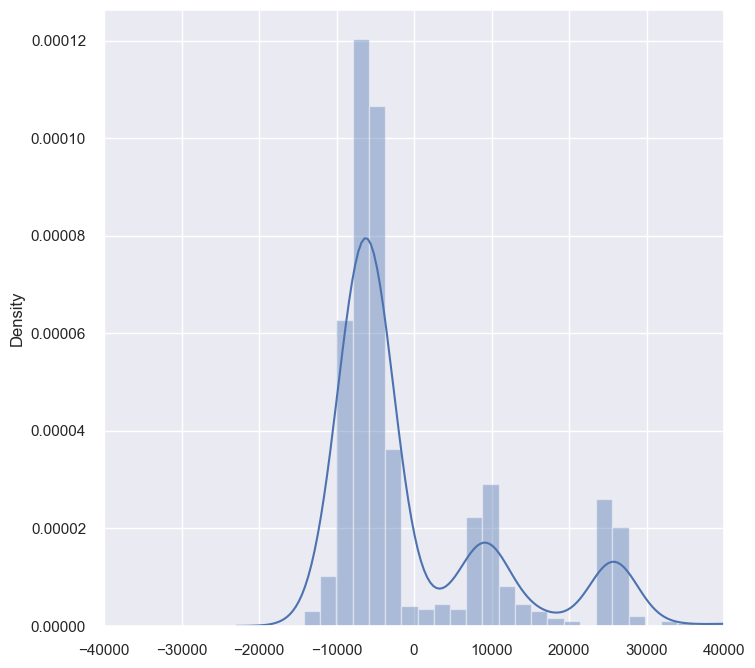

In [451]:
## Representamos los residuos (valor real - estimado)
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim([-40000,40000])
sns.distplot(result.resid,bins=30);

Nuestra hipotesis era que los residuos se ajustaban a una distribución normal, pero como podemos ver este no es el caso.
Esto nos indica que nuestro modelo no es para nada bueno. El coeficiente de R^2 de arriba de 0.11 tambien nos indica que nuestro modelo tiene mucho que mejorar

### Regresion con unos datos mejor escogidos

probamos utilizando las variables categoricas a ver si obtenemos un mejor resultado

como hemos visto en el analísis previo, la unica variable categorica relevante para el coste es si se es fumador o no, las otras no son relevantes 
(de hecho nos da la misma R^2 las pongamos o no)

In [452]:
medical = load_medical_costs()
#medical['sex'] = medical['sex'].astype('category').cat.codes
medical['smoker'] = medical['smoker'].astype('category').cat.codes
#dummies = pd.get_dummies(medical['region'], drop_first=True, prefix='region', prefix_sep='_')
medical.drop(columns=['region'], inplace=True)
medical.drop(columns=['sex'], inplace=True)
#medical = pd.concat([medical,dummies], axis=1);

df = medical

medical.head()


,age,bmi,children,smoker,charges
0,19,27.900,0,1,16884.924
1,18,33.770,1,0,1725.552
2,28,33.000,3,0,4449.462
3,33,22.705,0,0,21984.471
4,32,28.880,0,0,3866.855


In [453]:
X = medical.loc[:,medical.columns != 'charges']
y = medical['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [454]:
# Instanciamos el modelo LinearRegression 
lr = LinearRegression();

# Ajustamos con los datos de entrenamiento con el método fit
lr.fit(X_train,y_train);

# Predecimos con el método predict 
y_pred = lr.predict(X_train);
weights = lr.coef_
intercept = lr.intercept_
# Podemos acceder a información del modelo, como los pesos.
print('Coeficientes: \n', weights[:10])
print('Interceptor: \n', intercept)
model = sm.OLS(y_train, sm.add_constant(X_train))
result = model.fit()
result.summary()

LinearRegression()

Coeficientes: 
 [  261.84974458   333.40735476   433.22607604 23626.55992417]
Interceptor: 
 -12470.177642441275


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     667.1
Date:                Thu, 27 Oct 2022   Prob (F-statistic):          1.42e-271
Time:                        06:40:56   Log-Likelihood:                -9494.7
No. Observations:                 936   AIC:                         1.900e+04
Df Residuals:                     931   BIC:                         1.902e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.247e+04   1159.558    -10.754      0.000   -1.47e+04   -1.02e+04
age          261.8497     14.416     18.164      0.000     233.558     290.142
bmi          333.4074     33.854      9.849      0.000     266.969     399.845
children     433.2261    166.827      2.597      0.010     105.825     760.627
smoker      2.363e+04    497.414     47.499      0.000    2.27e+04    2.46e+04
==============================================================================
Omnibus:                      224.219   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              538.846
Skew:                           1.270   Prob(JB):                    9.80e-118
Kurtosis:                       5.714   Cond. No.                         295.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

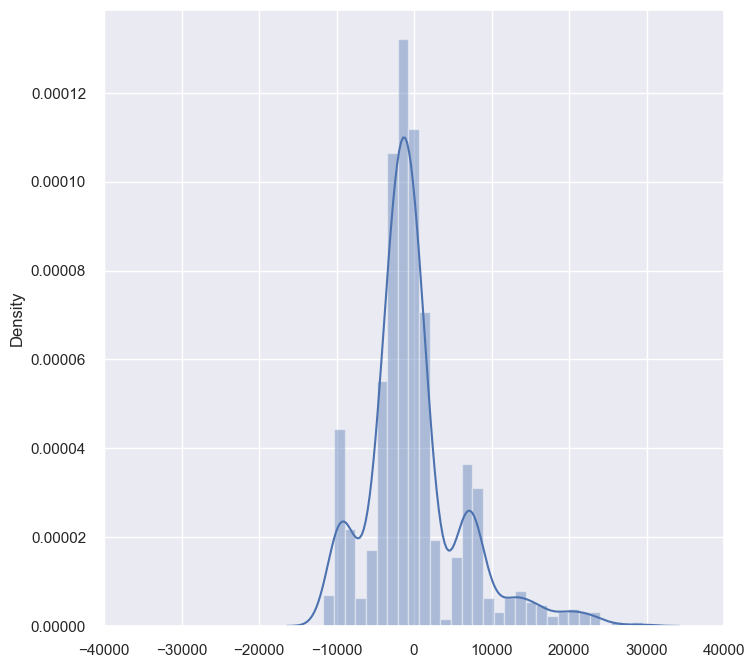

In [455]:
## Representamos los residuos (valor real - estimado)
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim([-40000,40000])
sns.distplot(result.resid,bins=30);

si usamos las variables categoricas obtenemos un resultado mejor que parece ajustarse a una distribución normal, aunque con R^2 de 0.74, lo cual se pude mejorar


## <strong> c) La relación entre las variables del conjunto de datos y la variable objetivo podrían ser no lineal. Usa la función PolynomialFeatures de scikit-learn para añadir características al conjunto de datos que correspondan a polinomios de grado 2.
</strong>

In [482]:
##usaremos el segundo set del apartado anterior como base, ya que es el que tiene un mejor resultado
from sklearn.preprocessing import PolynomialFeatures
from pandas import DataFrame
trans = PolynomialFeatures(degree=2)
medical = df
#medical.drop(columns=['smoker'], inplace=True) ##<-- testeo
len(medical.columns)

5

In [483]:
medical = DataFrame(trans.fit_transform(medical))
len(medical.columns)
medical.head()
##la columna 5 es la de los cargos

21

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,1.0,19.0,27.900,0.0,1.0,16884.924,361.0,530.100,0.0,19.0,320813.556,778.410,0.00,27.9,471089.380,0.0,0.0,0.000,1.0,16884.924,2.851e+08
1,1.0,18.0,33.770,1.0,0.0,1725.552,324.0,607.860,18.0,0.0,31059.941,1140.413,33.77,0.0,58271.901,1.0,0.0,1725.552,0.0,0.000,2.978e+06
2,1.0,28.0,33.000,3.0,0.0,4449.462,784.0,924.000,84.0,0.0,124584.936,1089.000,99.00,0.0,146832.246,9.0,0.0,13348.386,0.0,0.000,1.980e+07
3,1.0,33.0,22.705,0.0,0.0,21984.471,1089.0,749.265,0.0,0.0,725487.530,515.517,0.00,0.0,499157.405,0.0,0.0,0.000,0.0,0.000,4.833e+08
4,1.0,32.0,28.880,0.0,0.0,3866.855,1024.0,924.160,0.0,0.0,123739.366,834.054,0.00,0.0,111674.778,0.0,0.0,0.000,0.0,0.000,1.495e+07


In [484]:
X = medical.loc[:,medical.columns != 5]
y = medical[5]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### <strong>d) Ajusta a estos nuevos datos un modelo de regresión lineal y uno de regresión LASSO yestima la calidad de la regresión. ¿Te parece suficientemente bueno el resultado de los modelos? Representa los residuos y comenta que aparece. ¿Qué modelo te parece mejor?¿Por qué?</strong>



### Regresion Lineal

In [485]:
# Instanciamos el modelo LinearRegression 
lr = LinearRegression();

# Ajustamos con los datos de entrenamiento con el método fit
lr.fit(X_train,y_train);

# Predecimos con el método predict 
y_pred = lr.predict(X_train);
weights = lr.coef_
intercept = lr.intercept_
# Podemos acceder a información del modelo, como los pesos.
print('Coeficientes: \n', weights[:230])
print('Interceptor: \n', intercept)
model = sm.OLS(y_train, sm.add_constant(X_train))
result = model.fit()
result.summary()


LinearRegression()

Coeficientes: 
 [ 0.00000000e+00  2.77442213e+02  3.85956010e+02  6.06902885e+02
  1.11017935e+04 -8.23356231e-01 -8.04047477e+00 -6.70428991e+00
 -1.20704295e+02  4.70102016e-03 -4.42676612e+00 -1.23347996e+01
 -7.30119754e+02  2.70609210e-02 -1.72218023e+01 -3.44039533e+02
  9.78137396e-03  1.11017935e+04  1.81433632e-01 -2.47384116e-06]
Interceptor: 
 -7417.105272295143


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      5   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     8972.
Date:                Thu, 27 Oct 2022   Prob (F-statistic):               0.00
Time:                        07:05:19   Log-Likelihood:                -7704.9
No. Observations:                 936   AIC:                         1.545e+04
Df Residuals:                     917   BIC:                         1.554e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0          -7417.1053    749.295     -9.899      0.000   -8887.637   -5946.573
1            277.4422     18.878     14.697      0.000     240.393     314.491
2            385.9560     40.604      9.505      0.000     306.269     465.643
3            606.9029    177.899      3.411      0.001     257.766     956.040
4            1.11e+04    259.317     42.812      0.000    1.06e+04    1.16e+04
6             -0.8234      0.227     -3.633      0.000      -1.268      -0.379
7             -8.0405      0.375    -21.463      0.000      -8.776      -7.305
8             -6.7043      2.202     -3.045      0.002     -11.026      -2.383
9           -120.7043     11.915    -10.130      0.000    -144.089     -97.320
10             0.0047      0.000     10.023      0.000       0.004       0.006
11            -4.4268      0.629     -7.036      0.000      -5.662      -3.192
12           -12.3348      4.628     -2.665      0.008     -21.417      -3.252
13          -730.1198     27.883    -26.186      0.000    -784.841    -675.399
14             0.0271      0.001     48.814      0.000       0.026       0.028
15           -17.2218     18.830     -0.915      0.361     -54.176      19.733
16          -344.0395    115.743     -2.972      0.003    -571.191    -116.888
17             0.0098      0.004      2.263      0.024       0.001       0.018
18           1.11e+04    259.317     42.812      0.000    1.06e+04    1.16e+04
19             0.1814      0.029      6.271      0.000       0.125       0.238
20         -2.474e-06   6.64e-07     -3.727      0.000   -3.78e-06   -1.17e-06
==============================================================================
Omnibus:                      505.244   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12991.962
Skew:                           1.930   Prob(JB):                         0.00
Kurtosis:                      20.839   Cond. No.                     2.31e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.54e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

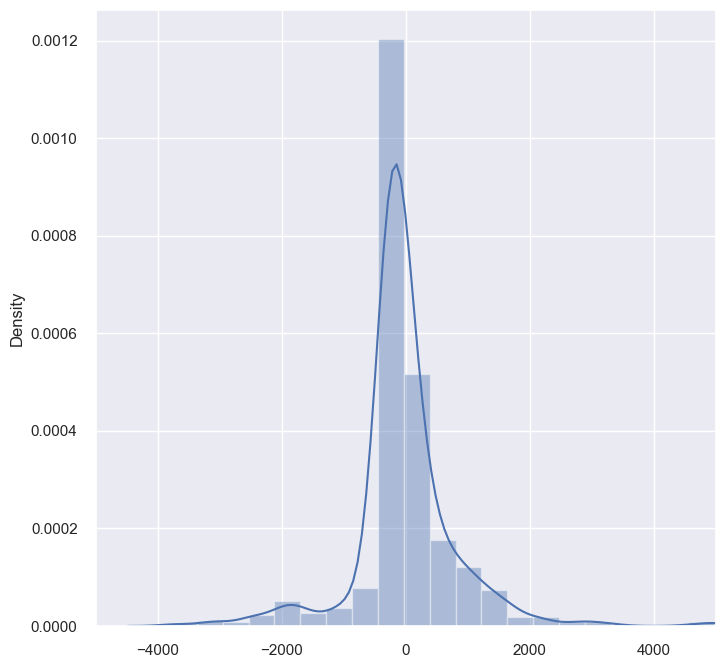

In [486]:
## Representamos los residuos (valor real - estimado)
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim([-5000,5000])
sns.distplot(result.resid,bins=30);

Después de aplicar las PolynomialFeatures se puede ver el el histograma de resiudos que la mayoria caen cerca del cero y siguen una distribución Gaussiana, que es en lo que basabamos nuestra hypotesis para calcular la regressión. Además obtenemos un R^2 de 0.99. Podemos decir que este modelo dará una predicción muy acertada de los costos de tratamiento


<Figure size 1200x800 with 0 Axes>

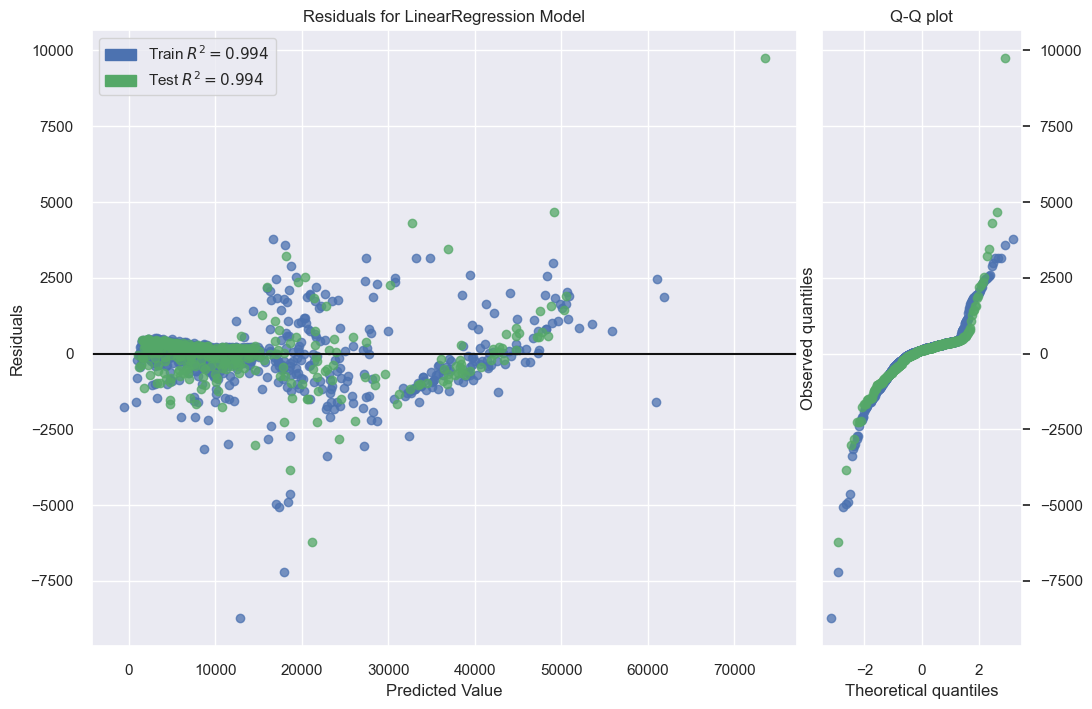

<Figure size 800x800 with 0 Axes>

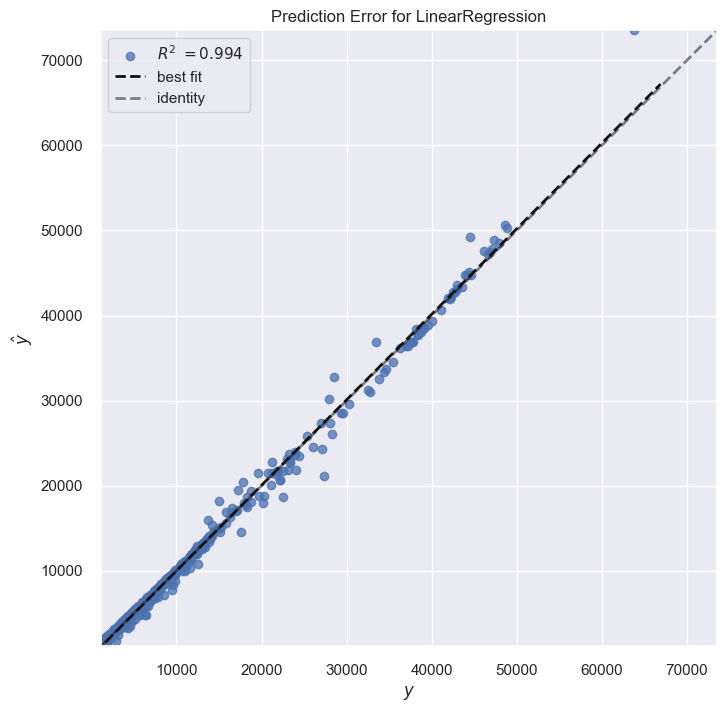

In [487]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(12,8));
viz = residuals_plot(lr, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);
from yellowbrick.regressor import prediction_error

plt.figure(figsize=(8,8))
visualizer = prediction_error(lr, X_test, y_test, is_fitted=True)


En este QQplot vemos que se ajusta bastante bien a lo esperado, y la recta de prediccion se solapa con la de los valores reales.
De hecho el PolynomialFeatures funciona tan bien que aunque no useoms el atributo de fumador solo perdemos un 0.01 en R^2


### Regresión LASSO

Esta vez penalizamos los pesos usando su norma L1.


$\min_w (|| y - Xw ||^2 + \lambda * |w|)$

Usaremos el método CV de scikit-learn para calcular la mejor $\lambda$ directamente.


In [488]:
lambdas = [1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]
lasso_cv =LassoCV(alphas=lambdas,cv=5).fit(X_train,y_train)

lasso_r2 =  np.mean(cross_val_score(lasso_cv, X_train,y_train))
folds_r2 = cross_val_score(lr, X_train,y_train, cv=5, scoring='r2')
print('Best lambda:', lasso_cv.alpha_, 'R2 score:',lasso_r2)

Best lambda: 0.0001 R2 score: 0.9933489207731435
Best lambda: 0.0001 R2 score: 0.9933489207731435


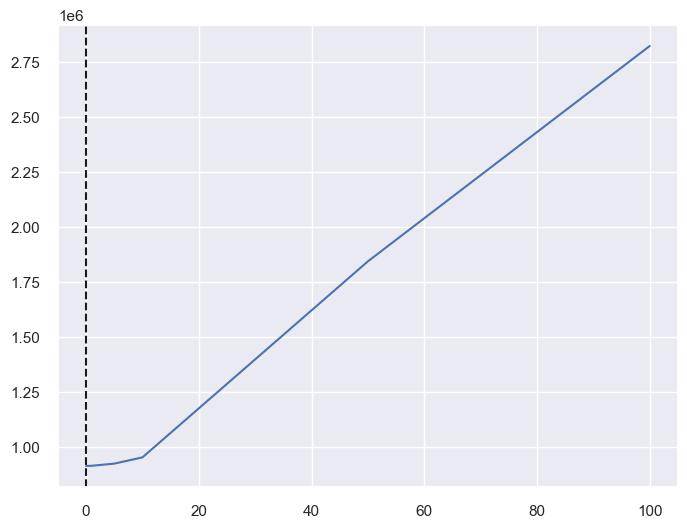

In [489]:
plt.figure(figsize=(8,6))
vis = AlphaSelection(LassoCV(alphas=lambdas));
vis.fit(X_train, y_train);


## Conclusión
La regressión LASSO nos da un resultado muy similar, aunque un poco peor, que la regressión lineal cuando tiene un coeficiente lambda muy pequeño (1e-04), lo que acerca bastante la formula de la LASSO a la de la regressión lineal. 